# Collaboration and Competetion

---

*Jun Zhu, zhujun981661@gmail.com, 09.2020*

In this notebook, I present the solution for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')
from maddpg_agent import MaDdpgAgent
from utilities import check_environment, play, plot_score_history, plot_losses

Next, we will start the environment! Before running the code cell below, change the file_name parameter to match the location of the Unity environment that you downloaded.

    Mac: "path/to/Tennis.app"
    Windows (x86): "path/to/Tennis_Windows_x86/Tennis.exe"
    Windows (x86_64): "path/to/Tennis_Windows_x86_64/Tennis.exe"
    Linux (x86): "path/to/Tennis_Linux/Tennis.x86"
    Linux (x86_64): "path/to/Tennis_Linux/Tennis.x86_64"
    Linux (x86, headless): "path/to/Tennis_Linux_NoVis/Tennis.x86"
    Linux (x86_64, headless): "path/to/Tennis_Linux_NoVis/Tennis.x86_64"

For instance, if you are using a Mac, then you downloaded Tennis.app. If this file is in the same folder as the notebook, then the line below should appear as follows:

env = UnityEnvironment(file_name="Tennis.app")

In [2]:
env = UnityEnvironment(file_name='Tennis_Linux/Tennis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. *It should be noted that the output of the environment consists of a stack of three observations, i.e., 24 variables*. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

Run the code cell below to print some information about the environment.

In [4]:
brain_name, state_space, action_space, n_agents = check_environment(env, return_n_agents=True)
brain_name

Brain name:  TennisBrain
Brain:  Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 
Number of agents: 2
States look like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
States have length: 24
Number of actions: 2


'TennisBrain'

### 3. Take Random Actions in the Environment

In [5]:
# play(env, brain_name, repeats=11, continuous=True)

### 4. Train a MADDPG (Multi-Agent Deep Deterministic Policy Gradient) agent

The multi-agent actor-critic algorithm proposed by [R. Lowe, et al.,](https://arxiv.org/abs/1706.02275) was implemented. This is a general-purpose multi-agent learning algorithm that could be applied not just to cooperative games with explicit communication channels, but competitive games and games involving only physical interactions between agents. As illustrated in the picture below, this algorithm adopts centralized training with decentralized execution. More specifically, it allows the policies to use extra information to ease training (the critic of an agent is augmented with extra information about the policies of other agents) so long as the information is not used in the test. The information augmentation ensures that the environment is stationary (Markov assumption) even as the policies change.

<img src="multi_agent_actor_critic.png" alt="[Multi-agent actor-critic" width="400"/>

In [6]:
def init_final_layer(layer):
    layer.weight.data.uniform_(-3e-3, 3e-3)
    layer.bias.data.uniform_(-3e-3, 3e-3)


class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self._fc1 = nn.Linear(state_space, 256)
        self._fc2 = nn.Linear(256, 1024)
        self._fc3 = nn.Linear(1024, 256)
        self._fc_final = nn.Linear(256, action_space)

        self._bn1 = nn.BatchNorm1d(256)
        self._bn2 = nn.BatchNorm1d(1024)
        self._bn3 = nn.BatchNorm1d(256)

        init_final_layer(self._fc_final)
        
    def forward(self, state):
        x = state
        x = F.leaky_relu(self._bn1(self._fc1(x)), negative_slope=0.01)
        x = F.leaky_relu(self._bn2(self._fc2(x)), negative_slope=0.01)
        x = F.leaky_relu(self._bn3(self._fc3(x)), negative_slope=0.01)

        return torch.tanh(self._fc_final(x))
    

class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        
        self._fc1 = nn.Linear(n_agents * (state_space + action_space), 256)
        self._fc2 = nn.Linear(256, 1024)
        self._fc3 = nn.Linear(1024, 256)
        self._fc_final = nn.Linear(256, 1)

        self._bn1 = nn.BatchNorm1d(256)
        self._bn2 = nn.BatchNorm1d(1024)
        self._bn3 = nn.BatchNorm1d(256)

        init_final_layer(self._fc_final)

    def forward(self, states, actions):
        x = torch.cat([states, actions], dim=-1)
        x = F.relu(self._bn1(self._fc1(x)))
        x = F.relu(self._bn2(self._fc2(x)))
        x = F.relu(self._bn3(self._fc3(x)))

        return self._fc_final(x)

In [7]:
target_score = 0.5

# initialize the agent
agent = MaDdpgAgent(state_space, action_space, n_agents, (Actor, Critic), replay_memory_size=int(1e5),
                    model_file="maddpg_checkpoint.pth")

# train the agent with given hyperparameters (remove ./maddpg_checkpoint.pth to train a new model from scratch)
scores, losses_actor, losses_critic = agent.train(env,
    theta=1.0,  # Ornstein-Uhlenbeck process constant (note an episode is very short)
    sigma=0.5,  # Ornstein-Uhlenbeck process constant
    decay_rate=0.999,  # noise decay rate
    tau=0.001,  # soft update rate of the target network
    gamma=0.99,  # discount factor
    learning_rate=(2e-4, 2e-4),  # learning rates of actor and critic models
    weight_decay=(0e-6, 0e-5),  # L2 penalties of actor and critic models
    batch_size=256,  # mini batch size
    n_trainings_per_step=1,  # number of trainings per time step.
    replay_start_size=5000, # required number of samples in the buffer before training starts
    n_episodes=3000,
    target_score=target_score,  # to check the long term stability of the training
    continue_after_reaching_target=False,
    save_frequency=500,
    output_frequency=20)

Loaded existing model ended at epoch: 2160 with averagescore of   0.7103
Score of the current model   0.7103 is already higher than the target score 0.5!


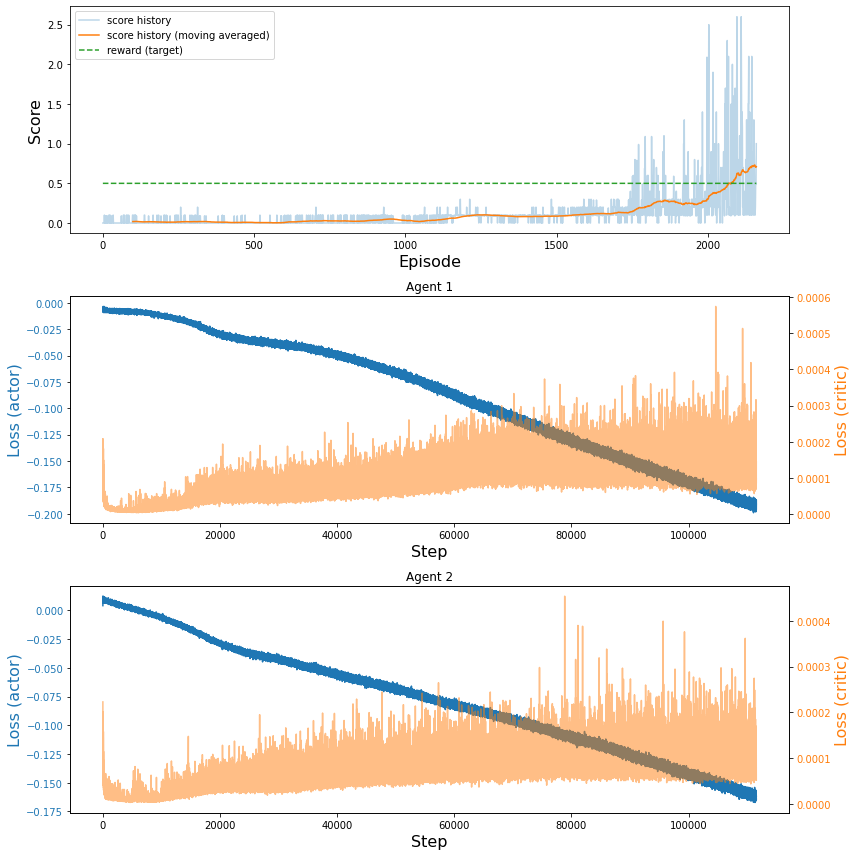

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
plot_score_history(ax[0], scores, target_score)
plot_losses(ax[1], losses_actor[0], 'Loss (actor)', losses_critic[0], 'Loss (critic)')
ax[1].set_title("Agent 1")
plot_losses(ax[2], losses_actor[1], 'Loss (actor)', losses_critic[1], 'Loss (critic)')
ax[2].set_title("Agent 2")

fig.tight_layout()

In [9]:
play(env, brain_name, agent, repeats=21)

Score of play 01:       0.1000
Score of play 02:       0.3000
Score of play 03:       0.9000
Score of play 04:       0.3000
Score of play 05:       0.3000
Score of play 06:       0.2900
Score of play 07:       0.6000
Score of play 08:       0.9900
Score of play 09:       0.5900
Score of play 10:       0.7000
Score of play 11:       0.1000
Score of play 12:       0.7000
Score of play 13:       0.1000
Score of play 14:       0.6000
Score of play 15:       0.8000
Score of play 16:       1.9000
Score of play 17:       0.1000
Score of play 18:       0.1000
Score of play 19:       1.1000
Score of play 20:       0.4900
Score of play 21:       0.3000


In [10]:
env.close()

### 5. Further improvement

Since the assumption of knowing other agents' policies is strong in a real world environment, in the [MADDPG paper]((https://arxiv.org/abs/1706.02275)), the author also proposed two possible improvements:

- Inferring Policies of Other Agents

  In order to remove the assumption of knowing the policies of the other agents, each agent can maintain an approximation to the true policy for each of the other agents. The approximate policies can be learned by maximizing the log probabilities of the actions of the other agents.

- Agents with Policy Ensembles

  In a competitive settings, an agent could derive a strong policy by overfitting to the behavior of their   competitors. Such policies are undesirable as they are brittle and may fail when the competitors alter strategies. To obtain more robust policies, one can train a collection of K different sub-policies. At each episode, one particular sub-policy is randomly selected for each agent to execute.